# Implementation of lccv

In [58]:
import typing
import logging

import numpy as np
import pandas as pd
import scipy.stats
import time
import sklearn.metrics
import pynisher

import inspect
import traceback

import matplotlib.pyplot as plt


def format_learner(learner):
    learner_name = str(learner).replace("\n", " ").replace("\t", " ")
    for k in  range(20):
        learner_name = learner_name.replace("  ", " ")
    return learner_name


def _partition_train_test_data(
        features: np.array, labels: np.array, n_test: int,
        seed: int) -> typing.Tuple[np.array, np.array, np.array, np.array]:
    """
    Partitions the dataset in a test set of the size of the requested size, and
    a train set of size n_train.

    :param features: The X-data
    :param labels: The y-data
    :param n_test: the requested test size
    :param seed: The random seed
    :return: A 4-tuple, consisting of the train features (2D np.array), the
    train labels (1D np.array), the test features (2D np.array) and the test
    labels (1D np.array)
    """
    if seed is None:
        raise ValueError('Seed can not be None (to ensure test set equality)')
    np.random.seed(seed)
    indices = np.arange(features.shape[0])
    np.random.shuffle(indices)
    features = features[indices]
    labels = labels[indices]

    return features[n_test:], labels[n_test:], features[:n_test], labels[:n_test]


class EmpiricalLearningModel:
    
    def __init__(
            self,
            learner,
            X,
            y,
            n_target,
            seed,
            fix_train_test_folds,
            evaluator,
            evaluator_kwargs,
            base_scoring,
            additional_scorings,
            use_train_curve,
            raise_errors
    ):
        """

        :param learner:
        :param X:
        :param y:
        :param n_target:
        :param seed:
        :param fix_train_test_folds:
        :param evaluator:
        :param base_scoring: either a string (sklearn scorer) or a tuple `(name, descriptor)`,
            where `name` is a string and `descriptor` is  either
                (i) a scoring function, if it does not need to know the set of available labels or
                (ii), it should be a dictionary with the arguments required by `make_scorer` except "labels",
                    which will be filled by LCCV when building the scorer.
        :param additional_scorings: iterable of scorings described in the same way as `base_scoring`
        :param raise_errors: whether or not to raise errors (if not risen, they are logged via error)
        """
        
        # set up logger
        self.logger = logging.getLogger('elm')
        
        self.learner = learner
        self.active_seed = seed
        self.fix_train_test_folds = fix_train_test_folds
        self.use_train_curve = use_train_curve
        self.raise_errors = raise_errors

        # set evaluator and scoring
        self.evaluator = evaluator if evaluator is not None else self.evaluate
        if not callable(self.evaluator):
            raise Exception(f"Evaluator is of type {type(self.evaluator)}, which is not a callable.")
        self.evaluator_kwargs = evaluator_kwargs

        # set scoring functions
        self.base_scoring = base_scoring
        self.additional_scorings = list(additional_scorings)

        # the data is only used if no evaluator is given
        if evaluator is None:
            
            if X.shape[0] <= 0:
                raise Exception(f"Recieved dataset with non-positive number of instances. Shape is {X.shape}")
            
            n_test = X.shape[0] - n_target # portion of data that exceeds the target value is used for testing
            
            if fix_train_test_folds:
                self.X_train, self.y_train, self.X_test, self.y_test = _partition_train_test_data(X, y, n_test, seed)
                self.logger.info(f"Train labels: \n{self.y_train}")
                self.logger.info(f"Test labels: \n{self.y_test}")
            else:
                self.X = X
                self.y = y
                self.n_test = n_test

        """
        if a scoring function is given as a string, the existing labels are added through make_scorer.
        this is a work-around since sklearn does not allow to provide the labels when getting a scoring with get_scorer
        it is also necessary here and NOT in the constructor, because the labels must be the ones used in the training set.
        """
        for i, scoring in enumerate([self.base_scoring] + self.additional_scorings):
            if type(scoring) == str:
                tmp_scorer = sklearn.metrics.get_scorer(scoring)
                needs_labels = "labels" in inspect.signature(tmp_scorer._score_func).parameters
                kws = {
                    "score_func": tmp_scorer._score_func,
                    "greater_is_better": tmp_scorer._sign == 1,
                    "needs_proba": type(tmp_scorer) == sklearn.metrics._scorer._ProbaScorer,
                    "needs_threshold": type(tmp_scorer) == sklearn.metrics._scorer._ThresholdScorer,
                }
                if needs_labels:
                    kws["labels"] = list(np.unique(y))
                scoring = (scoring, sklearn.metrics.make_scorer(**kws))
            elif type(scoring) != tuple:
                raise ValueError(
                    f"{'base_scoring' if i == 0 else f'The {i-1}th additional scoring'}"
                    f"is of type {type(scoring)} but must be a string or a tuple of size 2."
                )
            elif len(scoring) != 2:
                raise ValueError(
                    f"{'base_scoring' if i == 0 else f'The {i - 1}th additional scoring'}"
                    f"has length {len(scoring)} but should have length 2."
                )
            elif type(scoring[0]) != str:
                raise ValueError(
                    f"{'base_scoring' if i == 0 else f'The {i - 1}th additional scoring'}"
                    f"requires a str in the first field for the name but has {type(scoring[0])}."
                )
            elif not callable(scoring[1]):
                raise ValueError(
                    f"Scoring is of type {type(self.scoring)}, which is not a callable."
                    "Make sure to pass a string or Callable."
                )
            if i == 0:
                self.base_scoring = scoring
            else:
                self.additional_scorings[i - 1] = scoring

        columns = ["anchor", "seed", "fittime"]
        for scoring, _ in [self.base_scoring] + self.additional_scorings:
            columns.extend([
                f"scoretime_train_{scoring}",
                f"score_train_{scoring}",
                f"scoretime_test_{scoring}",
                f"score_test_{scoring}"
            ])

        # initialize data
        self.df = pd.DataFrame([], columns=columns)
        self.rs = np.random.RandomState(seed)

    def evaluate(self, learner_inst, anchor, timeout, base_scoring, additional_scorings):

        self.active_seed += 1
        self.logger.debug("Computing training data")
        
        # obtain train and test data (depending on configuration)
        if self.fix_train_test_folds:
            self.logger.info("Re-using pre-defined train and test folds")
            X_train, y_train, X_test, y_test = self.X_train, self.y_train, self.X_test, self.y_test
        else:
            X_train, y_train, X_test, y_test = _partition_train_test_data(self.X, self.y, self.n_test, self.active_seed)
            self.logger.info(f"Dynamically creating a train and test fold with seed {self.active_seed}.")
        
        indices = self.rs.choice(X_train.shape[0], anchor)
        X_train = X_train[indices]
        y_train = y_train[indices]
        self.logger.debug(f"Created train portion. Labels in train/test data: {len(np.unique(y_train))}/{len(np.unique(y_test))}")
        
        hash_before = hash(X_train.tobytes())
        learner_inst = sklearn.base.clone(learner_inst)
        self.logger.info(f"Training {format_learner(learner_inst)} on data of shape {X_train.shape}. Timeout is {timeout}")
        start_eval = time.time()
        if timeout is None:
            learner_inst.fit(X_train, y_train)
        elif timeout > 1:
            with pynisher.limit(func=learner_inst.fit, wall_time=timeout) as executor:
                learner_inst = executor(X_train, y_train)
        else:
            raise pynisher.WallTimeoutException()

        end = time.time()
        self.logger.debug(f"Training ready after {int((end - start_eval) * 1000)}ms. Now obtaining predictions.")
        results = {
            "fittime": end - start_eval
        }
        for scoring_name, scoring_fun in [base_scoring] + additional_scorings:
            start = time.time()
            try:
                if timeout is None:
                    score_test = scoring_fun(learner_inst, X_test, y_test)
                elif timeout > start - start_eval + 1:
                    with pynisher.limit(func=scoring_fun, wall_time=timeout - (start - start_eval)) as executor:
                        score_test = executor(learner_inst, X_test, y_test)
                else:
                    raise pynisher.WallTimeoutException()
            except KeyboardInterrupt:
                raise
            except pynisher.WallTimeoutException:
                raise
            except Exception as e:
                if self.raise_errors:
                    raise
                else:
                    self.logger.error(f"{traceback.format_exc()}")
                    score_test = np.nan
            runtime_test = time.time() - start

            if self.use_train_curve:
                start = time.time()
                try:
                    if timeout is None:
                        score_train = scoring_fun(learner_inst, X_train, y_train)
                    elif timeout > start - start_eval + 1:
                        with pynisher.limit(func=scoring_fun, wall_time=timeout - (start - start_eval)) as executor:
                            score_train = executor(learner_inst, X_train, y_train)
                    else:
                        raise pynisher.WallTimeoutException()
                except KeyboardInterrupt:
                    raise
                except pynisher.WallTimeoutException:
                    raise
                except Exception as e:
                    if self.raise_errors:
                        raise
                    else:
                        self.logger.error(f"{traceback.format_exc()}")
                        score_train = np.nan
                runtime_train = time.time() - start
            else:
                score_train, runtime_train = np.nan, 0
            results.update({
                f"scoretime_train_{scoring_name}": runtime_train,
                f"score_train_{scoring_name}": score_train,
                f"scoretime_test_{scoring_name}": runtime_test,
                f"score_test_{scoring_name}": score_test
            })
        end = time.time()
        self.logger.info(
            f"Evaluation ready after {int((end - start) * 1000)}ms."
            "Score of model on {y_test.shape[0]} validation/test instances is {score_test}."
        )
        hash_after = hash(X_train.tobytes())
        if hash_before != hash_after:
            raise Exception(
                "Evaluation of pipeline has changed the data."
                "Please make sure to evaluate pipelines that do not change the data in place."
            )
        return results
    
    def compute_and_add_sample(self, anchor, seed=None, timeout=None, verbose=False):
        evaluation_result = self.evaluator(
            self.learner,
            anchor,
            timeout / 1000 if timeout is not None else None,
            self.base_scoring,
            self.additional_scorings,
            **self.evaluator_kwargs
        )

        row = [
            anchor,
            seed,
            evaluation_result["fittime"]
        ]
        for scoring_name, _ in [self.base_scoring] + self.additional_scorings:
            row.extend([
                evaluation_result[f"scoretime_train_{scoring_name}"],
                evaluation_result[f"score_train_{scoring_name}"],
                evaluation_result[f"scoretime_test_{scoring_name}"],
                evaluation_result[f"score_test_{scoring_name}"]
            ])
        self.logger.debug(f"Sample value computed. Extending database.")
        self.df.loc[len(self.df)] = row
        self.df = self.df.astype({"anchor": int, "seed": int})
        scoring = self.base_scoring[0]
        return evaluation_result[f"score_train_{scoring}"], evaluation_result[f"score_test_{scoring}"]
    
    def get_values_at_anchor(self, anchor, scoring=None, test_scores = True):
        if scoring is None:
            scoring = self.base_scoring[0]
        col = "score_" + ("test" if test_scores else "train") + "_" + scoring
        return self.df[self.df["anchor"] == anchor][col].values
    
    def get_best_worst_train_score(self, scoring = None):
        if scoring is None:
            scoring = self.base_scoring[0]
        return max([min(g) for i, g in self.df.groupby("anchor")[f"score_train_{scoring}"]])
    
    def get_mean_performance_at_anchor(self, anchor, scoring=None, test_scores=True):
        return np.mean(self.get_values_at_anchor(anchor, scoring=scoring, test_scores=test_scores))
    
    def get_mean_curve(self, test_scores = True):
        anchors = sorted(pd.unique(self.df["anchor"]))
        return anchors, [self.get_mean_performance_at_anchor(a, test_scores = test_scores) for a in anchors]
    
    def get_runtimes_at_anchor(self, anchor):
        return self.df[self.df["anchor"] == anchor][[c for c in self.df.columns if "time" in c]]
    
    def get_conf_interval_size_at_target(self, target):
        if len (self.df[self.df["anchor"] == target]) == 0:
            return 1
        ci = self.get_normal_estimates(anchor = target)["conf"]
        return ci[1] - ci[0]
    
    def get_lc_estimate_at_target(self, target):
        return self.get_mmf()[1](target)
    
    def get_normal_estimates(self, anchor = None, round_precision=100, scoring=None, validation = True):

        if anchor is None:
            anchors = sorted(np.unique(self.df["anchor"]))
            out = {}
            for anchor in anchors:
                out[int(anchor)] = self.get_normal_estimates(anchor)
            return out

        if scoring is None:
            scoring = self.base_scoring[0]

        dfProbesAtAnchor = self.df[self.df["anchor"] == anchor]
        mu = np.mean(dfProbesAtAnchor["score_" + ("test" if validation else "train") + "_" + scoring])
        sigma = np.std(dfProbesAtAnchor["score_" + ("test" if validation else "train") + "_" + scoring])
        return {
            "n": len(dfProbesAtAnchor["score_" + ("test" if validation else "train") + "_" + scoring]),
            "mean": np.round(mu, round_precision),
            "std": np.round(sigma, round_precision),
            "conf": np.round(scipy.stats.norm.interval(0.95, loc=mu, scale=sigma/np.sqrt(len(dfProbesAtAnchor))) if sigma > 0 else (mu, mu), round_precision)
        }
    
    def get_slope_ranges(self):
        est = self.get_normal_estimates()
        anchors = [s for s in est]
        ranges = []
        for i, anchor in enumerate(anchors):
            if i > 0:
                anchor_prev_last = anchors[i - 1]
                anchor_last = anchors[i]
                
                # compute confidence bounds of prev last and last anchor
                if est[anchor_prev_last]["n"] > 1:
                    lower_prev_last = est[anchor_prev_last]["conf"][0]
                    upper_prev_last = est[anchor_prev_last]["conf"][1]
                else:
                    lower_prev_last = upper_prev_last = est[anchor_prev_last]["mean"]
                if est[anchor_last]["n"] > 1:
                    lower_last = est[anchor_last]["conf"][0]
                    upper_last = est[anchor_last]["conf"][1]
                else:
                    lower_last = upper_last = est[anchor_last]["mean"]
                
                # compute slope range
                pessimistic_slope = max(0, (lower_last - upper_prev_last) / (anchor_last - anchor_prev_last))
                optimistic_slope = max(0, (upper_last - lower_prev_last) / (anchor_last - anchor_prev_last))
                ranges.append((pessimistic_slope, optimistic_slope))
        return ranges
    
    def get_slope_range_in_last_segment(self):
        return self.get_slope_ranges()[-1]
    
    def get_performance_interval_at_target(self, target):
        pessimistic_slope, optimistic_slope = self.get_slope_range_in_last_segment()
        anchors = sorted(np.unique(self.df["anchor"]))
        last_anchor = anchors[-1]
        normal_estimates = self.get_normal_estimates()[last_anchor]
        if normal_estimates["n"] > 1:
            last_conf = normal_estimates["conf"]
            if normal_estimates["std"] > 0:
                last_conf_lower = last_conf[0]
                last_conf_upper = last_conf[1]
            else:
                last_conf_lower = last_conf_upper = normal_estimates["mean"]
                last_conf = (last_conf_lower, last_conf_upper)
        else:
            last_conf_lower = last_conf_upper = normal_estimates["mean"]
            last_conf = (last_conf_lower, last_conf_upper)
        if any(np.isnan(last_conf)):
            return last_conf
        if np.isnan(optimistic_slope):
            raise Exception("Slope must not be nan")
        return pessimistic_slope * (target - last_anchor) + last_conf_lower, optimistic_slope * (target - last_anchor) + last_conf_upper
        
    def get_ipl(self):
        anchors = sorted(list(pd.unique(self.df["anchor"])))
        scores = [np.mean(self.df[self.df["anchor"] == a][f"{self.base_scoring[0]}_val"]) for a in anchors]

        def ipl(beta):
            a, b, c = tuple(beta.astype(float))
            pl = lambda x: a + b * x **(-c)
            penalty = []
            for i, anchor in enumerate(anchors):
                penalty.append((pl(anchor) - scores[i])**2)
            return np.array(penalty)

        a, b, c = tuple(scipy.optimize.least_squares(ipl, np.array([1, 1, 1]), method="lm").x)
        return lambda x: a + b * x **(-c)
    
    def get_mmf(self, validation_curve=True, scoring=None):
        anchors = sorted(list(pd.unique(self.df["anchor"])))
        if scoring is None:
            scoring = self.base_scoring[0]
        scores = [
            np.mean(self.df[self.df["anchor"] == a]["score_" + ("test" if validation_curve else "train") + "_" + scoring])
            for a in anchors
        ]
        weights = [2**i for i in range(len(anchors))]
        def mmf(beta):
            a, b, c, d = tuple(beta.astype(float))
            fun = lambda x: (a * b + c * x ** d)/(b + x ** d)
            penalties = []
            for i, anchor in enumerate(anchors):
                penalty = weights[i]  * ((scores[i] - fun(anchor)) ** 2) # give more weights on higher anchors
                penalties.append(penalty if not np.isnan(penalty) else 10**6)
            return sum(penalties)
        
        factor = 1 if validation_curve else -1
        const = {
            "type": "ineq", "fun": lambda x: -factor * x[1] * (x[2]-x[0])*x[3]
        }

        a, b, c, d = tuple(scipy.optimize.minimize(mmf, np.array([0.5,1,1,-1]), constraints=const).x)
        return (a, b, c, d), lambda x: (a * b + c * x ** d)/(b + x ** d)
    
    def predict_runtime(self, target_anchor):
        lr = sklearn.linear_model.LinearRegression()
        X = self.df[["anchor"]].values
        X = np.row_stack([X, [[0]]])
        X = np.column_stack([X, X[:]**2])
        #runtime
        y = self.df["fittime"].values
        y = np.append(y, [0])
        lr.fit(X, y)
        b = np.abs(lr.coef_[0])
        a = np.abs(lr.coef_[1])
        return a * (target_anchor**2) + b * target_anchor + lr.intercept_
    
    def get_max_size_for_runtime(self, runtime):
        lr = sklearn.linear_model.LinearRegression()
        X = self.df[["anchor"]].values
        X = np.row_stack([X, [[0]]])
        X = np.column_stack([X, X[:]**2])
        y = self.df["runtime"].values
        y = np.append(y, [0])
        lr.fit(X, y)
        b = np.abs(lr.coef_[0])
        a = np.abs(lr.coef_[1])
        inner = (-b/(2 * a))**2 - (lr.intercept_ - runtime) / a
        return -b/(2 * a) + np.sqrt(inner)
    
    def visualize(self, max_anchor = 1000, r = None):
        anchors = sorted(list(pd.unique(self.df["anchor"])))
        scores_train = [self.get_normal_estimates(a, validation=False) for a in anchors]
        scores_valid = [self.get_normal_estimates(a, validation=True) for a in anchors]
        lc_train_params, lc_train = self.get_mmf(False)
        lc_test_params, lc_valid = self.get_mmf(True)
        
        fig, ax = plt.subplots()
        ax.scatter(anchors, [e["mean"] for e in scores_train])
        ax.scatter(anchors, [e["mean"] for e in scores_valid])
        domain = np.linspace(64, max_anchor, 100)
        ax.plot(domain, lc_train(domain), color="C0")
        ax.fill_between(anchors, [v["mean"] - v["std"] for v in scores_train], [v["mean"] + v["std"] for v in scores_train], alpha=0.2, color="C0")
        ax.plot(domain, lc_valid(domain), color="C1")
        ax.fill_between(anchors, [v["mean"] - v["std"] for v in scores_valid], [v["mean"] + v["std"] for v in scores_valid], alpha = 0.2, color="C1")
        
        # create lines that project based on convexity
        val_at_target_pessimistic, val_at_target_optimistic = self.get_performance_interval_at_target(max_anchor)
        ax.plot([anchors[-2], max_anchor], [scores_valid[-2]["mean"] + scores_valid[-2]["std"], val_at_target_pessimistic], color="C3", linestyle="--")
        ax.plot([anchors[-2], max_anchor], [scores_valid[-2]["mean"] - scores_valid[-2]["std"], val_at_target_optimistic], color="C2", linestyle="--")
        
        if r is not None:
            ax.axhline(r, color="black", linestyle="--")
        plt.show()
    

def lccv(
        learner_inst,
        X,
        y,
        r,
        timeout=None,
        base=2,
        min_exp=6,
        MAX_ESTIMATE_MARGIN_FOR_FULL_EVALUATION=0.005,
        MAX_EVALUATIONS=10,
        target_anchor=.9,
        schedule=None,
        return_estimate_on_incomplete_runs=False,
        max_conf_interval_size_default=0.1,
        max_conf_interval_size_target=0.001,
        enforce_all_anchor_evaluations=False,
        seed=0,
        verbose=False,
        logger=None,
        min_evals_for_stability=3,
        use_train_curve=True,
        fix_train_test_folds=False,
        evaluator=None,
        evaluator_kwargs={},
        base_scoring="accuracy",
        additional_scorings=[],
        visualize_lcs = False,
        raise_exceptions = True
):
    """
    Evaluates a learner in an iterative fashion, using learning curves. The
    method builds upon the assumption that learning curves are convex. After
    each iteration, it checks whether the convexity assumption is still valid.
    If not, it tries to repair it.
    Also, after each iteration it checks whether the performance of the best
    seen learner so far is still reachable by making an optimistic extrapolation.
    If not, it stops the evaluation.

    :param learner_inst: The learner to be evaluated
    :param X: The features on which the learner needs to be evaluated
    :param y: The labels on which the learner needs to be trained
    :param r: The best seen performance so far (lower is better). Fill in 0.0 if
    no learners have been evaluated prior to the learner.
    :param timeout: The maximal runtime for this specific leaner. Fill in None
    to avoid cutting of the evaluation.
    :param base: The base factor to increase the sample sizes of the learning
    curve.
    :param min_exp: The first exponent of the learning curve.
    :param MAX_ESTIMATE_MARGIN_FOR_FULL_EVALUATION: The maximum number of
    evaluations to be performed
    :param MAX_EVALUATIONS:
    :param target_anchor:
    :param schedule: define the anchors for which scores should be computed
    :param return_estimate_on_incomplete_runs:
    :param max_conf_interval_size_default:
    :param max_conf_interval_size_target:
    :param enforce_all_anchor_evaluations:
    :param seed:
    :param verbose:
    :param logger:
    :param min_evals_for_stability:
    :param use_train_curve: If True, then the evaluation stops as soon as the train curve drops under the threshold r
    :param evaluator: Function to be used to query a noisy score at some anchor. To be maximized!
    :param evaluator_kwargs: arguments to be forwarded to the evaluator function
    :param base_scoring: either a string (sklearn scorer) or a tuple `(name, descriptor)`,
            where `name` is a string and `descriptor` is  either
                (i) a scoring function, if it does not need to know the set of available labels or
                (ii), it should be a dictionary with the arguments required by `make_scorer` except "labels",
                    which will be filled by LCCV when building the scorer.
        :param additional_scorings: iterable of scorings described in the same way as `base_scoring`
    :return:
    """
    # create standard logger if none is given
    if logger is None:
        logger = logging.getLogger('lccv')
    logger.debug("timeout = " + str(timeout) + ", " +
                 "BASE = " + str(base) + ", " +
                 "min_exp = " + str(min_exp) + ", " +
                 "MAX_ESTIMATE_MARGIN_FOR_FULL_EVALUATION = " + str(MAX_ESTIMATE_MARGIN_FOR_FULL_EVALUATION) + ", " +
                 "MAX_EVALUATIONS = " + str(MAX_EVALUATIONS) + ", " +
                 "target_anchor = " + str(target_anchor) + ", " +
                 "return_estimate_on_incomplete_runs = " + str(return_estimate_on_incomplete_runs) + ", " +
                 "max_conf_interval_size_default = " + str(max_conf_interval_size_default) + ", " +
                 "max_conf_interval_size_target = " + str(max_conf_interval_size_target) +  ", " +
                 "enforce_all_anchor_evaluations = " + str(enforce_all_anchor_evaluations) +  ", " +
                 "seed = " + str(seed) +  ", " +
                 "min_evals_for_stability = " + str(min_evals_for_stability) + ", " +
                 "fix_train_test_folds = " + str(fix_train_test_folds))
    # intialize
    tic = time.time()
    deadline = tic + timeout if timeout is not None else None

    # configure the exponents and status variables
    if target_anchor < 1:
        if X is None:
            raise Exception(
                "If no data is given, the `target_anchor` parameter must be specified as a positive integer."
            )
        target_anchor = int(np.floor(X.shape[0] * target_anchor))
    
    # initialize important variables and datastructures
    max_exp = np.log(target_anchor) / np.log(base)
    if schedule is None:
        schedule = [base**i for i in list(range(min_exp, int(np.ceil(max_exp))))] + [target_anchor]
    elif any(np.argsort(schedule) != list(range(len(schedule)))):
        raise ValueError("parameter `schedule` must be sorted")
    slopes = (len(schedule) - 1) * [np.nan]
    elm = EmpiricalLearningModel(
        learner=learner_inst,
        X=X,
        y=y,
        n_target=target_anchor,
        seed=seed,
        fix_train_test_folds=fix_train_test_folds,
        evaluator=evaluator,
        evaluator_kwargs=evaluator_kwargs,
        base_scoring=base_scoring,
        additional_scorings=additional_scorings,
        use_train_curve=use_train_curve,
        raise_errors=raise_exceptions
    )
    T = len(schedule) - 1
    t = 0 if r < np.inf or enforce_all_anchor_evaluations else T
    repair_convexity = False
    
    # announce start event together with state variable values
    logger.info(f"""Running LCCV {'on ' + str(X.shape) + '-shaped data' if X is not None else 'with custom evaluator.'}. Overview:
    learner: {format_learner(learner_inst)}
    r: {r}
    min_exp: {min_exp}
    max_exp: {max_exp}
    Seed is {seed}
    t_0: {t}
    Schedule: {schedule}""")
    
    # MAIN LOOP
    while t <= T and elm.get_conf_interval_size_at_target(target_anchor) > max_conf_interval_size_target and len(elm.get_values_at_anchor(target_anchor)) < MAX_EVALUATIONS:
        
        remaining_time = deadline - time.time() - 0.1 if deadline is not None else np.inf
        if remaining_time < 1:
            logger.info("Timeout observed, stopping outer loop of LCCV")
            break
        
        # initialize stage-specific variables
        eps = max_conf_interval_size_target if t == T else max_conf_interval_size_default
        s_t = schedule[t]
        num_evaluations_at_t = len(elm.get_values_at_anchor(s_t))
        logger.info(f"Running iteration for t = {t}. Anchor point s_t is {s_t}. Remaining time: {remaining_time}s")
        
        # INNER LOOP: acquire observations at anchor until stability is reached, or just a single one to repair convexity
        while repair_convexity or num_evaluations_at_t < min_evals_for_stability or (elm.get_conf_interval_size_at_target(s_t) > eps and num_evaluations_at_t < MAX_EVALUATIONS):
            
            remaining_time = deadline - time.time() - 0.1 if deadline is not None else np.inf
            if remaining_time < 1:
                logger.info("Timeout observed, stopping inner loop of LCCV")
                break
            
            # unset flag for convexity repair
            repair_convexity = False
            
            # compute next sample
            try:
                seed_used = 13 * (1 + seed) + num_evaluations_at_t
                logger.debug(f"Adding point at anchor {s_t} with seed is {seed_used}. Remaining time: {remaining_time}s")
                score_train, score_test = elm.compute_and_add_sample(s_t, seed_used, (deadline - time.time() - 0.1) * 1000 if deadline is not None else None, verbose=verbose)
                num_evaluations_at_t += 1
                logger.debug(f"Sample computed successfully. Observed performance was {np.round(score_train, 4)} (train) and {np.round(score_test, 4)} (test).")
            except pynisher.WallTimeoutException:
                timeouted = True
                logger.info("Observed timeout. Stopping LCCV.")
                break
            except Exception:
                if raise_exceptions:
                    raise
                logger.warning(
                    f"Observed an exception at anchor {s_t}."
                    "Set raise_exceptions=True if you want this to cause the evaluation to fail."
                    f"Trace: {traceback.format_exc()}"
                )
                score_train, score_test = np.nan, np.nan
                num_evaluations_at_t += 1
            
            # check wheter a repair is needed
            if num_evaluations_at_t >= min_evals_for_stability and t < T and t > 2:                    
                slopes = elm.get_slope_ranges()
                if len(slopes) < 2:
                    raise Exception(f"There should be two slope ranges for t > 2 (t is {t}), but we observed only 1.")
                if slopes[t - 2] > slopes[t - 1] and len(elm.get_values_at_anchor(schedule[t - 1])) < MAX_EVALUATIONS:
                    repair_convexity = True
                    break

        # check training curve
        if use_train_curve != False:
            
            check_training_curve = (type(use_train_curve) == bool) or (callable(use_train_curve) and use_train_curve(learner_inst, s_t))
            
            if check_training_curve and elm.get_best_worst_train_score() < r:
                logger.info(f"Train curve has value {elm.get_best_worst_train_score()} that is already worse than r = {r}. Stopping.")
                break
        
        # after the last stage, we dont need any more tests
        if t == T:
            logger.info("Last iteration has been finished. Not testing anything else anymore.")
            break
        
        # now decide how to proceed
        if repair_convexity:
            t -= 1
            logger.debug(f"Convexity needs to be repaired, stepping back. t is now {t}")
        elif t >= 2 and elm.get_performance_interval_at_target(target_anchor)[1] < r:
            
            if visualize_lcs:
                logger.debug(f"Visualizing curve")
                elm.visualize(schedule[-1], r)
            
            estimate_for_target_performance = elm.get_performance_interval_at_target(target_anchor)
            optimistic_estimate_for_target_performance = estimate_for_target_performance[1]
            
            # prepare data for cut-off summary
            pessimistic_slope, optimistic_slope = elm.get_slope_range_in_last_segment()
            estimates = elm.get_normal_estimates()
            anchors = sorted(np.unique(elm.df["anchor"]))
            i = -1
            if min_evals_for_stability > 1:
                while len(elm.df[elm.df["anchor"] == anchors[i]]) < 2:
                    i -= 1
            last_anchor = s_t
            normal_estimates_last = estimates[last_anchor]
            last_conf = normal_estimates_last["conf"]
            
            # inform about cut-off
            logger.info(f"Impossibly reachable. Best possible score by bound is {optimistic_estimate_for_target_performance}. Stopping after anchor s_t = {s_t} and returning nan.")
            logger.debug(f"""Details about stop:
            Data:
            {elm.df}
            Normal Estimates: """ + ''.join(["\n\t\t" + str(s_t) + ": " + (str(estimates[s_t]) if s_t in estimates else "n/a") for s_t in schedule]) + "\n\tSlope Ranges:" + ''.join(["\n\t\t" + str(schedule[i]) + " - " + str(schedule[i + 1]) + ": " +  str(e) for i, e in enumerate(elm.get_slope_ranges())]) + f"""
            Last anchor: {last_anchor}
            Optimistic offset at last evaluated anchor {last_anchor}: {last_conf[1]}
            Optimistic slope from last segment: {optimistic_slope}
            Remaining steps: {(target_anchor - last_anchor)}
            Estimated interval at target anchor {target_anchor} (pessimistic, optimistic): {estimate_for_target_performance}""")
            return np.nan, normal_estimates_last["mean"], estimates, elm

        elif not enforce_all_anchor_evaluations and (elm.get_mean_performance_at_anchor(s_t) > r or (t >= 3 and elm.get_lc_estimate_at_target(target_anchor) >= r - MAX_ESTIMATE_MARGIN_FOR_FULL_EVALUATION)):
            t = T
            if (elm.get_mean_performance_at_anchor(s_t) > r):
                logger.info(f"Current mean is {elm.get_mean_performance_at_anchor(s_t)}, which is already an improvement over r = {r}. Hence, stepping to full anchor.")
            else:
                logger.info(f"Candidate appears to be competitive (predicted performance at {target_anchor} is {elm.get_lc_estimate_at_target
y(target_anchor)}. Jumping to last anchor in schedule: {t}")
        else:
            t += 1
            logger.info(f"Finished schedule on {s_t}, and t is now {t}. Performance: {elm.get_normal_estimates(s_t, 4)}.")
            if t < T:
                estimates = elm.get_normal_estimates()
                logger.debug(
                    "LC: "
                    ''.join(["\n\t" + str(s_t) + ": " + (str(estimates[s_t]) if s_t in estimates else "n/a") + ". Avg. runtime: " + str(np.round(elm.get_runtimes_at_anchor(s_t).mean() / 1000, 1)) for s_t in schedule if len(elm.get_runtimes_at_anchor(s_t)) > 0])
                )
                if t > 2:
                    logger.debug(
                        f"Estimate for target anchor {target_anchor}:"
                        f"{elm.get_performance_interval_at_target(target_anchor)[1]}"
                    )
    
    # output final reports
    toc = time.time()
    estimates = elm.get_normal_estimates()
    logger.info(f"""Learning Curve Construction Completed. Summary:
    Runtime: {int(1000*(toc-tic))}ms.
    LC: """
                ''.join(["\n\t\t" + str(s_t) + ":\t" + (", ".join([str(k) + ": " + str(np.round(v, 4)) for k, v in estimates[s_t].items()]) if s_t in estimates else "n/a") + ". Avg. runtime: " + str(np.round(elm.get_runtimes_at_anchor(s_t).mean(), 1)) for s_t in schedule if len(elm.get_runtimes_at_anchor(s_t)) > 0])
                )
    
    # return result depending on observations and configuration
    if len(estimates) == 0 or elm.get_best_worst_train_score() < r:
        logger.info(f"Observed no result or a train performance that is worse than r. In either case, returning nan.")
        return np.nan, np.nan, dict() if len(estimates) == 0 else estimates, elm
    elif len(estimates) < 3:
        max_anchor = max([int(k) for k in estimates])
        if visualize_lcs:
            logger.debug(f"Visualizing curve")
            elm.visualize(schedule[-1], r)
        return estimates[max_anchor]["mean"], estimates[max_anchor]["mean"], estimates, elm
    else:
        max_anchor = max([int(k) for k in estimates])
        target_performance = estimates[max_anchor]["mean"] if t == T or not return_estimate_on_incomplete_runs else elm.get_lc_estimate_at_target(target_anchor)
        logger.info(f"Target performance: {target_performance}")
        if visualize_lcs:
            logger.debug(f"Visualizing curve")
            elm.visualize(schedule[-1], r)
        return target_performance, estimates[max_anchor]["mean"], estimates, elm


# Testing of lccv

In [2]:
import sklearn.datasets
import sklearn.linear_model
import sklearn.tree
import openml

In [3]:
openmlid = 41161
X, y = sklearn.datasets.fetch_openml(data_id=openmlid, return_X_y=True)

# Running with out timeout

In [4]:
%%time
lccv(sklearn.linear_model.LogisticRegression(), X, y,r=0.70)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

KeyboardInterrupt: 

# Running with timeout

In [10]:
%%time
lccv.lccv(sklearn.linear_model.LogisticRegression(), X, y,r=0.70,timeout=5)

Wall time: 6.5 s


(0.6915,
 0.6915,
 {64: {'n': 1, 'mean': 0.6915, 'std': 0.0, 'conf': array([0.6915, 0.6915])}},
 <lccv.lccv.EmpiricalLearningModel at 0x1bb53fdb880>)

# Running with all anchor evaluations

In [11]:
%%time
lccv.lccv(sklearn.tree.DecisionTreeClassifier(), X, y,r=1.0,enforce_all_anchor_evaluations=True, timeout=500, verbose=True)

Wall time: 8min 27s


(0.8107500000000001,
 0.8107500000000001,
 {64: {'n': 3,
   'mean': 0.643,
   'std': 0.022807162617622286,
   'conf': array([0.61719174, 0.66880826])},
  128: {'n': 3,
   'mean': 0.6715,
   'std': 0.02108316864230799,
   'conf': array([0.64764259, 0.69535741])},
  256: {'n': 4,
   'mean': 0.721,
   'std': 0.01566445019782056,
   'conf': array([0.70564912, 0.73635088])},
  512: {'n': 3,
   'mean': 0.7136666666666667,
   'std': 0.008106924338010187,
   'conf': array([0.70449299, 0.72284035])},
  1024: {'n': 3,
   'mean': 0.7383333333333333,
   'std': 0.018665178512108794,
   'conf': array([0.71721208, 0.75945458])},
  2048: {'n': 3,
   'mean': 0.7708333333333334,
   'std': 0.003399346342395193,
   'conf': array([0.76698668, 0.77467999])},
  4096: {'n': 2,
   'mean': 0.8107500000000001,
   'std': 0.0027499999999999747,
   'conf': array([0.80693876, 0.81456124])}},
 <lccv.lccv.EmpiricalLearningModel at 0x1bb53fdf190>)

# Example Useage

In [12]:
import sklearn.datasets
X1, y1 = sklearn.datasets.load_digits(return_X_y=True)

# Evaluating a Single Learner

In [27]:
import sklearn.linear_model
import sklearn.tree
r = 0.80
score, score_est, elc, model = lccv(sklearn.tree.DecisionTreeClassifier(), X1, y1, r = r)

# Score and Score Estimate
The score estimate is only relevant if the evaluation could not be finished in the given timeout, and if an extrapolation was used. Otherwise it is equal to the score.

In [28]:
print(score,score_est)

0.8511111111111112 0.8511111111111112


# Summary of the observations on the Empirical Learning Curve

In [29]:
elc

{64: {'n': 3,
  'mean': 0.6407407407407407,
  'std': 0.022831162973959138,
  'conf': array([0.61490532, 0.66657616])},
 128: {'n': 3,
  'mean': 0.688888888888889,
  'std': 0.036004114991154794,
  'conf': array([0.64814715, 0.72963063])},
 256: {'n': 5,
  'mean': 0.7111111111111112,
  'std': 0.0376796110173626,
  'conf': array([0.67808408, 0.74413814])},
 512: {'n': 4,
  'mean': 0.7847222222222221,
  'std': 0.033420026154211,
  'conf': array([0.7519712 , 0.81747325])},
 1024: {'n': 3,
  'mean': 0.8037037037037037,
  'std': 0.015930231976004856,
  'conf': array([0.78567728, 0.82173013])},
 1617: {'n': 10,
  'mean': 0.8511111111111112,
  'std': 0.0359869660904481,
  'conf': array([0.82880657, 0.87341565])}}

# Detailed Observations Made on the Empirical Learning Curve

In [30]:
model.df

,anchor,seed,fittime,scoretime_train_accuracy,score_train_accuracy,scoretime_test_accuracy,score_test_accuracy
0,64,13,0.004500,0.001002,1.0,0.001001,0.666667
1,64,14,0.003001,0.001004,1.0,0.000999,0.644444
2,64,15,0.003004,0.000000,1.0,0.000994,0.611111
3,128,13,0.005410,0.000998,1.0,0.001126,0.672222
4,128,14,0.005071,0.000918,1.0,0.001002,0.655556
5,128,15,0.005002,0.001005,1.0,0.001005,0.738889
6,256,13,0.009087,0.000997,1.0,0.001006,0.777778
7,256,14,0.008931,0.001003,1.0,0.000997,0.683333
8,256,15,0.008999,0.000996,1.0,0.000999,0.677778
9,256,16,0.009514,0.000000,1.0,0.000997,0.688889


# Visualising the Data

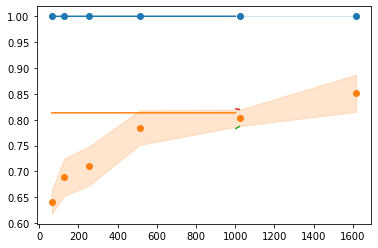

In [23]:
model.visualize()

# Utility functions

In [24]:
model.get_mean_curve()

([64, 128, 256, 512, 1024, 1617],
 [0.6407407407407407,
  0.688888888888889,
  0.7111111111111112,
  0.7847222222222221,
  0.8037037037037037,
  0.8511111111111112])

In [31]:
model.predict_runtime(64)

0.0030020953231632602

In [32]:
model.get_mmf()

((0.8132627779002709,
  1.3996457221939311,
  1.2410398162552345,
  -2.8182344361633027),
 <function __main__.EmpiricalLearningModel.get_mmf.<locals>.<lambda>(x)>)

# Making Recommendations on whether or not collect more data

In [33]:
def get_dataset(openmlid):
    ds = openml.datasets.get_dataset(openmlid)
    df = ds.get_data()[0]
    num_rows = len(df)
        
    # prepare label column as numpy array
    print(f"Read in data frame. Size is {len(df)} x {len(df.columns)}.")
    X = np.array(df.drop(columns=[ds.default_target_attribute]).values)
    y = np.array(df[ds.default_target_attribute].values)
    if y.dtype != int:
        y_int = np.zeros(len(y)).astype(int)
        vals = np.unique(y)
        for i, val in enumerate(vals):
            mask = y == val
            y_int[mask] = i
        y = y_int
        
    print(f"Data is of shape {X.shape}.")
    return X, y

In [55]:
def check_possible_improvement(learner, X, y):
    n = X.shape[0]
    target = int(0.9 * n)
    half = int(target/2)
    print("Conducting validation on " + str(half) + "/" + str(target) + " instances.")
    validation_score, mean_estimates, estimates, elm = lccv(learner(), X, y, r = 0.6, target_anchor = half, timeout=5,verbose=False)
    
    prediction_on_full = elm.get_lc_estimate_at_target(target)
    expected_improvement = validation_score - prediction_on_full
    print("Score at half size (" + str(half) + "):", validation_score)
    print("Estimated score on full data (" + str(target) + " instances):", prediction_on_full)
    print("This would be an improvement of:", expected_improvement)
    recommendation = expected_improvement >= 0.01
    print("Recommending to double the number of instances:", recommendation)
    
    # now computing the true performance there
    print("Now computing the TRUE performance at the target.")
    for seed in range(10):
        elm.compute_and_add_sample(target, seed=seed)
    true_performance_at_target = np.mean(elm.get_values_at_anchor(target))
    true_improvement_at_target = validation_score - true_performance_at_target
    print("True performance at target:", true_performance_at_target)
    print("The true improvement is:", true_improvement_at_target)
    print("Recommendation was " + ("bad" if (recommendation and true_improvement_at_target >= 0.01 or not recommendation and true_improvement_at_target < 0.01) else "good"))

    
learner = sklearn.tree.DecisionTreeClassifier
print("Conducting recommendation analysis now only for " + learner.__name__)

print("\n----------------- 1 -----------------")
print("Doing this on higgs. Here we *will* recognize saturation and the recommendation for more data will be good.")
openmlid = 23512
X, y = get_dataset(openmlid)
X[np.isnan(X)] = 0
check_possible_improvement(learner, X, y)

print("\n----------------- 2 -----------------")
print("Doing this on Madelon will be overly optimistic, but the recommendation for more data would still be correct.")
openmlid = 1485
X, y = get_dataset(openmlid)
check_possible_improvement(learner, X, y)

print("\n----------------- 3 -----------------")
print("We are also good in recognizing it on wine-quality-white!")
openmlid = 40498
X, y = get_dataset(openmlid)
check_possible_improvement(learner, X, y)

print("\n----------------- 4 -----------------")
print("On amazon, it works also well!")
openmlid = 1457
X, y = get_dataset(openmlid)
check_possible_improvement(learner, X, y)

Conducting recommendation analysis now only for DecisionTreeClassifier

----------------- 1 -----------------
Doing this on higgs. Here we *will* recognize saturation and the recommendation for more data will be good.
Read in data frame. Size is 98050 x 29.

<ipython-input-33-1580c5038de7>:2: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  ds = openml.datasets.get_dataset(openmlid)



Data is of shape (98050, 28).
Conducting validation on 44122/88245 instances.
Score at half size (44122): nan
Estimated score on full data (88245 instances): 0.5000056659791945
This would be an improvement of: nan
Recommending to double the number of instances: False
Now computing the TRUE performance at the target.
True performance at target: 0.6199376947040498
The true improvement is: nan
Recommendation was good

----------------- 2 -----------------
Doing this on Madelon will be overly optimistic, but the recommendation for more data would still be correct.


<ipython-input-33-1580c5038de7>:2: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  ds = openml.datasets.get_dataset(openmlid)


Read in data frame. Size is 2600 x 501.
Data is of shape (2600, 500).
Conducting validation on 1170/2340 instances.
Score at half size (1170): 0.4937062937062937
Estimated score on full data (2340 instances): 0.4860338064392878
This would be an improvement of: 0.007672487267005923
Recommending to double the number of instances: False
Now computing the TRUE performance at the target.
True performance at target: 0.6235664335664337
The true improvement is: -0.12986013986014
Recommendation was bad

----------------- 3 -----------------
We are also good in recognizing it on wine-quality-white!
Read in data frame. Size is 4898 x 12.
Data is of shape (4898, 11).
Conducting validation on 2204/4408 instances.


<ipython-input-33-1580c5038de7>:2: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  ds = openml.datasets.get_dataset(openmlid)


Score at half size (2204): 0.40682999257609503
Estimated score on full data (4408 instances): 0.3978698258709899
This would be an improvement of: 0.008960166705105133
Recommending to double the number of instances: False
Now computing the TRUE performance at the target.
True performance at target: 0.5213066072754268
The true improvement is: -0.11447661469933174
Recommendation was bad

----------------- 4 -----------------
On amazon, it works also well!


<ipython-input-33-1580c5038de7>:2: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  ds = openml.datasets.get_dataset(openmlid)


Read in data frame. Size is 1500 x 10001.
Data is of shape (1500, 10000).
Conducting validation on 675/1350 instances.
Score at half size (675): 0.08121212121212121
Estimated score on full data (1350 instances): 0.06873125271400155
This would be an improvement of: 0.012480868498119663
Recommending to double the number of instances: True
Now computing the TRUE performance at the target.
True performance at target: 0.33090909090909093
The true improvement is: -0.24969696969696972
Recommendation was good


In [40]:
#pip install openml
import openml
import lccv

# More than one learner

In [56]:
import sklearn.neural_network
import sklearn.discriminant_analysis
import sklearn.naive_bayes
import sklearn.ensemble
learners = [
    sklearn.svm.LinearSVC(),
    sklearn.tree.DecisionTreeClassifier(),
    sklearn.tree.ExtraTreeClassifier(),
    sklearn.linear_model.LogisticRegression(),
    sklearn.linear_model.PassiveAggressiveClassifier(),
    sklearn.linear_model.Perceptron(),
    sklearn.linear_model.RidgeClassifier(),
    sklearn.linear_model.SGDClassifier(),
    sklearn.neural_network.MLPClassifier(),
    sklearn.discriminant_analysis.LinearDiscriminantAnalysis(),
    sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis(),
    sklearn.naive_bayes.BernoulliNB(),
    sklearn.naive_bayes.MultinomialNB(),
    sklearn.neighbors.KNeighborsClassifier(),
    sklearn.ensemble.ExtraTreesClassifier(),
    sklearn.ensemble.RandomForestClassifier(),
    sklearn.ensemble.GradientBoostingClassifier(),
]

In [59]:
models={}
for i in learners:
    r = 0.80
    score, score_est, elc, model = lccv(i, X1, y1, r = r)
    models[i]=[score,model]
    #print(score,score_est,i)
    #model.visualize()
print(models)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\

{LinearSVC(): [0.93, <__main__.EmpiricalLearningModel object at 0x000001BB53F3D4C0>], DecisionTreeClassifier(): [0.846111111111111, <__main__.EmpiricalLearningModel object at 0x000001BB5642BF40>], ExtraTreeClassifier(): [0.7422222222222222, <__main__.EmpiricalLearningModel object at 0x000001BB55B3DF70>], LogisticRegression(): [0.95, <__main__.EmpiricalLearningModel object at 0x000001BB53FADE80>], PassiveAggressiveClassifier(): [0.9372222222222222, <__main__.EmpiricalLearningModel object at 0x000001BB546203D0>], Perceptron(): [0.925, <__main__.EmpiricalLearningModel object at 0x000001BB55A3D400>], RidgeClassifier(): [0.9266666666666665, <__main__.EmpiricalLearningModel object at 0x000001BB4E3FBDF0>], SGDClassifier(): [0.9405555555555557, <__main__.EmpiricalLearningModel object at 0x000001BB5413FEB0>], MLPClassifier(): [0.9666666666666666, <__main__.EmpiricalLearningModel object at 0x000001BB5440A130>], LinearDiscriminantAnalysis(): [0.9416666666666665, <__main__.EmpiricalLearningModel o

LinearSVC()


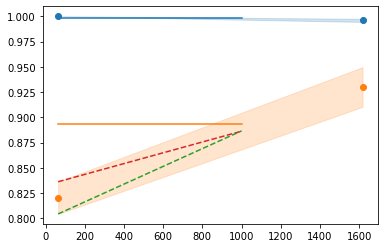

DecisionTreeClassifier()


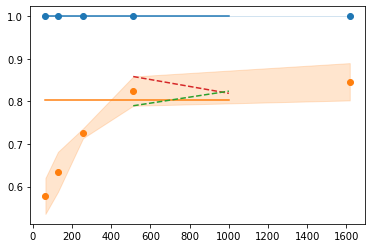

ExtraTreeClassifier()


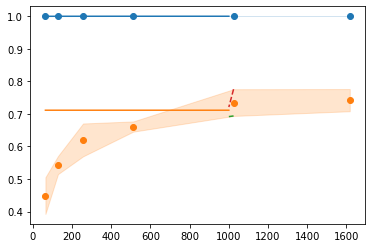

LogisticRegression()


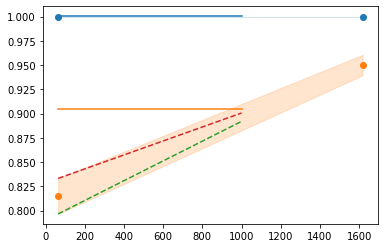

PassiveAggressiveClassifier()


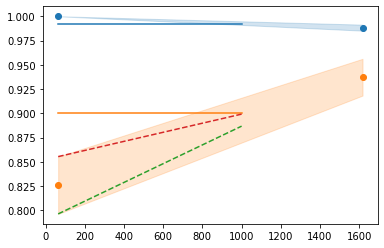

Perceptron()


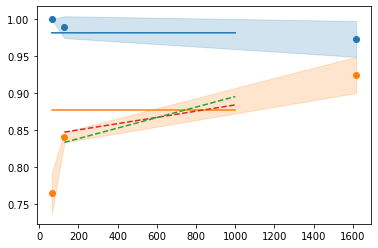

RidgeClassifier()


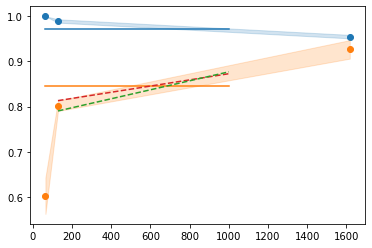

SGDClassifier()


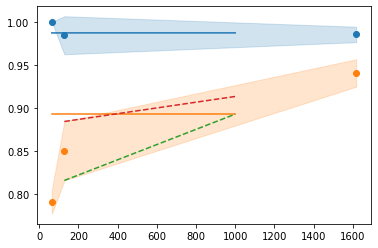

MLPClassifier()


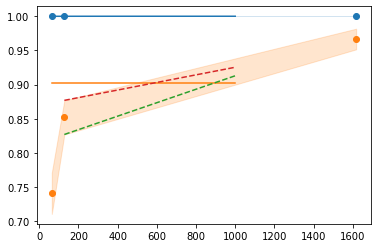

LinearDiscriminantAnalysis()


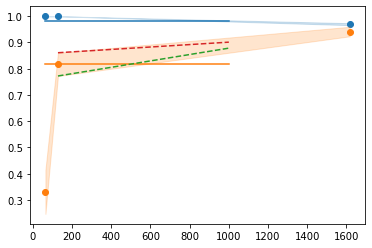

QuadraticDiscriminantAnalysis()


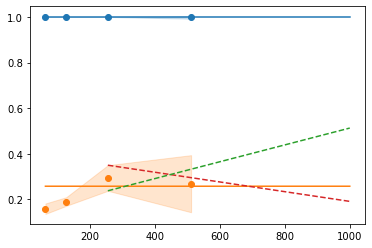

BernoulliNB()


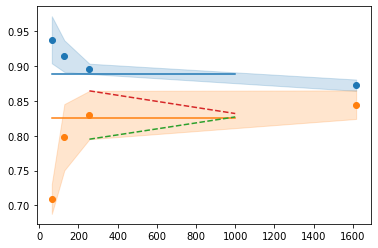

MultinomialNB()


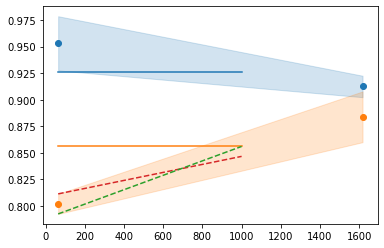

KNeighborsClassifier()


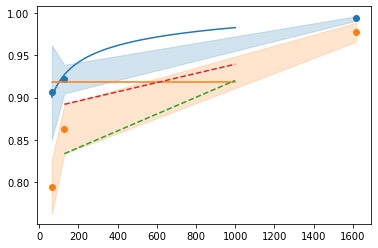

ExtraTreesClassifier()


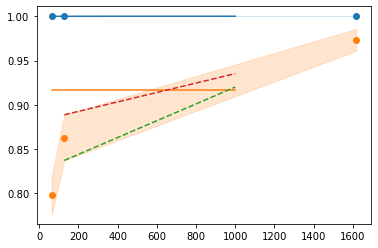

RandomForestClassifier()


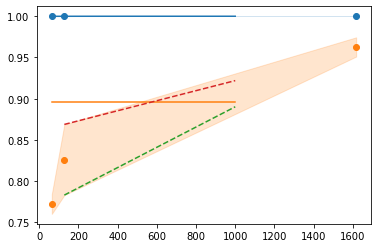

GradientBoostingClassifier()


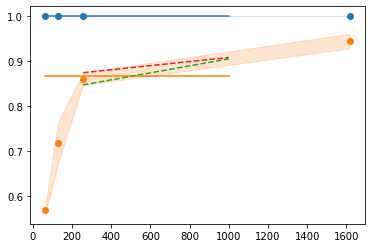

KNeighborsClassifier() 0.9772222222222223


In [60]:
m=-10**9
learner=''
for i in models:
    print(i)
    models[i][1].visualize()
    if models[i][0]>m:
        m=models[i][0]
        learner=i
print(learner,models[learner][0])
    

In [53]:
import typing
import logging

import numpy as np
import pandas as pd
import scipy.stats
import time
import sklearn.metrics
import pynisher

import inspect
import traceback

import matplotlib.pyplot as plt


def format_learner(learner):
    learner_name = str(learner).replace("\n", " ").replace("\t", " ")
    for k in  range(20):
        learner_name = learner_name.replace("  ", " ")
    return learner_name


def _partition_train_test_data(
        features: np.array, labels: np.array, n_test: int,
        seed: int) -> typing.Tuple[np.array, np.array, np.array, np.array]:
    """
    Partitions the dataset in a test set of the size of the requested size, and
    a train set of size n_train.

    :param features: The X-data
    :param labels: The y-data
    :param n_test: the requested test size
    :param seed: The random seed
    :return: A 4-tuple, consisting of the train features (2D np.array), the
    train labels (1D np.array), the test features (2D np.array) and the test
    labels (1D np.array)
    """
    if seed is None:
        raise ValueError('Seed can not be None (to ensure test set equality)')
    np.random.seed(seed)
    indices = np.arange(features.shape[0])
    np.random.shuffle(indices)
    features = features[indices]
    labels = labels[indices]

    return features[n_test:], labels[n_test:], features[:n_test], labels[:n_test]


class EmpiricalLearningModel:
    
    def __init__(
            self,
            learner,
            X,
            y,
            n_target,
            seed,
            fix_train_test_folds,
            evaluator,
            evaluator_kwargs,
            base_scoring,
            additional_scorings,
            use_train_curve,
            raise_errors
    ):
        """

        :param learner:
        :param X:
        :param y:
        :param n_target:
        :param seed:
        :param fix_train_test_folds:
        :param evaluator:
        :param base_scoring: either a string (sklearn scorer) or a tuple `(name, descriptor)`,
            where `name` is a string and `descriptor` is  either
                (i) a scoring function, if it does not need to know the set of available labels or
                (ii), it should be a dictionary with the arguments required by `make_scorer` except "labels",
                    which will be filled by LCCV when building the scorer.
        :param additional_scorings: iterable of scorings described in the same way as `base_scoring`
        :param raise_errors: whether or not to raise errors (if not risen, they are logged via error)
        """
        
        # set up logger
        self.logger = logging.getLogger('elm')
        
        self.learner = learner
        self.active_seed = seed
        self.fix_train_test_folds = fix_train_test_folds
        self.use_train_curve = use_train_curve
        self.raise_errors = raise_errors

        # set evaluator and scoring
        self.evaluator = evaluator if evaluator is not None else self.evaluate
        if not callable(self.evaluator):
            raise Exception(f"Evaluator is of type {type(self.evaluator)}, which is not a callable.")
        self.evaluator_kwargs = evaluator_kwargs

        # set scoring functions
        self.base_scoring = base_scoring
        self.additional_scorings = list(additional_scorings)

        # the data is only used if no evaluator is given
        if evaluator is None:
            
            if X.shape[0] <= 0:
                raise Exception(f"Recieved dataset with non-positive number of instances. Shape is {X.shape}")
            
            n_test = X.shape[0] - n_target # portion of data that exceeds the target value is used for testing
            
            if fix_train_test_folds:
                self.X_train, self.y_train, self.X_test, self.y_test = _partition_train_test_data(X, y, n_test, seed)
                self.logger.info(f"Train labels: \n{self.y_train}")
                self.logger.info(f"Test labels: \n{self.y_test}")
            else:
                self.X = X
                self.y = y
                self.n_test = n_test

        """
        if a scoring function is given as a string, the existing labels are added through make_scorer.
        this is a work-around since sklearn does not allow to provide the labels when getting a scoring with get_scorer
        it is also necessary here and NOT in the constructor, because the labels must be the ones used in the training set.
        """
        for i, scoring in enumerate([self.base_scoring] + self.additional_scorings):
            if type(scoring) == str:
                tmp_scorer = sklearn.metrics.get_scorer(scoring)
                needs_labels = "labels" in inspect.signature(tmp_scorer._score_func).parameters
                kws = {
                    "score_func": tmp_scorer._score_func,
                    "greater_is_better": tmp_scorer._sign == 1,
                    "needs_proba": type(tmp_scorer) == sklearn.metrics._scorer._ProbaScorer,
                    "needs_threshold": type(tmp_scorer) == sklearn.metrics._scorer._ThresholdScorer,
                }
                if needs_labels:
                    kws["labels"] = list(np.unique(y))
                scoring = (scoring, sklearn.metrics.make_scorer(**kws))
            elif type(scoring) != tuple:
                raise ValueError(
                    f"{'base_scoring' if i == 0 else f'The {i-1}th additional scoring'}"
                    f"is of type {type(scoring)} but must be a string or a tuple of size 2."
                )
            elif len(scoring) != 2:
                raise ValueError(
                    f"{'base_scoring' if i == 0 else f'The {i - 1}th additional scoring'}"
                    f"has length {len(scoring)} but should have length 2."
                )
            elif type(scoring[0]) != str:
                raise ValueError(
                    f"{'base_scoring' if i == 0 else f'The {i - 1}th additional scoring'}"
                    f"requires a str in the first field for the name but has {type(scoring[0])}."
                )
            elif not callable(scoring[1]):
                raise ValueError(
                    f"Scoring is of type {type(self.scoring)}, which is not a callable."
                    "Make sure to pass a string or Callable."
                )
            if i == 0:
                self.base_scoring = scoring
            else:
                self.additional_scorings[i - 1] = scoring

        columns = ["anchor", "seed", "fittime"]
        for scoring, _ in [self.base_scoring] + self.additional_scorings:
            columns.extend([
                f"scoretime_train_{scoring}",
                f"score_train_{scoring}",
                f"scoretime_test_{scoring}",
                f"score_test_{scoring}"
            ])

        # initialize data
        self.df = pd.DataFrame([], columns=columns)
        self.rs = np.random.RandomState(seed)

    def evaluate(self, learner_inst, anchor, timeout, base_scoring, additional_scorings):

        self.active_seed += 1
        self.logger.debug("Computing training data")
        
        # obtain train and test data (depending on configuration)
        if self.fix_train_test_folds:
            self.logger.info("Re-using pre-defined train and test folds")
            X_train, y_train, X_test, y_test = self.X_train, self.y_train, self.X_test, self.y_test
        else:
            X_train, y_train, X_test, y_test = _partition_train_test_data(self.X, self.y, self.n_test, self.active_seed)
            self.logger.info(f"Dynamically creating a train and test fold with seed {self.active_seed}.")
        
        indices = self.rs.choice(X_train.shape[0], anchor)
        X_train = X_train[indices]
        y_train = y_train[indices]
        self.logger.debug(f"Created train portion. Labels in train/test data: {len(np.unique(y_train))}/{len(np.unique(y_test))}")
        
        hash_before = hash(X_train.tobytes())
        learner_inst = sklearn.base.clone(learner_inst)
        self.logger.info(f"Training {format_learner(learner_inst)} on data of shape {X_train.shape}. Timeout is {timeout}")
        start_eval = time.time()
        if timeout is None:
            learner_inst.fit(X_train, y_train)
        elif timeout > 1:
            with pynisher.limit(func=learner_inst.fit, wall_time=timeout) as executor:
                learner_inst = executor(X_train, y_train)
        else:
            raise pynisher.WallTimeoutException()

        end = time.time()
        self.logger.debug(f"Training ready after {int((end - start_eval) * 1000)}ms. Now obtaining predictions.")
        results = {
            "fittime": end - start_eval
        }
        for scoring_name, scoring_fun in [base_scoring] + additional_scorings:
            start = time.time()
            try:
                if timeout is None:
                    score_test = scoring_fun(learner_inst, X_test, y_test)
                elif timeout > start - start_eval + 1:
                    with pynisher.limit(func=scoring_fun, wall_time=timeout - (start - start_eval)) as executor:
                        score_test = executor(learner_inst, X_test, y_test)
                else:
                    raise pynisher.WallTimeoutException()
            except KeyboardInterrupt:
                raise
            except pynisher.WallTimeoutException:
                raise
            except Exception as e:
                if self.raise_errors:
                    raise
                else:
                    self.logger.error(f"{traceback.format_exc()}")
                    score_test = np.nan
            runtime_test = time.time() - start

            if self.use_train_curve:
                start = time.time()
                try:
                    if timeout is None:
                        score_train = scoring_fun(learner_inst, X_train, y_train)
                    elif timeout > start - start_eval + 1:
                        with pynisher.limit(func=scoring_fun, wall_time=timeout - (start - start_eval)) as executor:
                            score_train = executor(learner_inst, X_train, y_train)
                    else:
                        raise pynisher.WallTimeoutException()
                except KeyboardInterrupt:
                    raise
                except pynisher.WallTimeoutException:
                    raise
                except Exception as e:
                    if self.raise_errors:
                        raise
                    else:
                        self.logger.error(f"{traceback.format_exc()}")
                        score_train = np.nan
                runtime_train = time.time() - start
            else:
                score_train, runtime_train = np.nan, 0
            results.update({
                f"scoretime_train_{scoring_name}": runtime_train,
                f"score_train_{scoring_name}": score_train,
                f"scoretime_test_{scoring_name}": runtime_test,
                f"score_test_{scoring_name}": score_test
            })
        end = time.time()
        self.logger.info(
            f"Evaluation ready after {int((end - start) * 1000)}ms."
            "Score of model on {y_test.shape[0]} validation/test instances is {score_test}."
        )
        hash_after = hash(X_train.tobytes())
        if hash_before != hash_after:
            raise Exception(
                "Evaluation of pipeline has changed the data."
                "Please make sure to evaluate pipelines that do not change the data in place."
            )
        return results
    
    def compute_and_add_sample(self, anchor, seed=None, timeout=None, verbose=False):
        evaluation_result = self.evaluator(
            self.learner,
            anchor,
            timeout / 1000 if timeout is not None else None,
            self.base_scoring,
            self.additional_scorings,
            **self.evaluator_kwargs
        )

        row = [
            anchor,
            seed,
            evaluation_result["fittime"]
        ]
        for scoring_name, _ in [self.base_scoring] + self.additional_scorings:
            row.extend([
                evaluation_result[f"scoretime_train_{scoring_name}"],
                evaluation_result[f"score_train_{scoring_name}"],
                evaluation_result[f"scoretime_test_{scoring_name}"],
                evaluation_result[f"score_test_{scoring_name}"]
            ])
        self.logger.debug(f"Sample value computed. Extending database.")
        self.df.loc[len(self.df)] = row
        self.df = self.df.astype({"anchor": int, "seed": int})
        scoring = self.base_scoring[0]
        return evaluation_result[f"score_train_{scoring}"], evaluation_result[f"score_test_{scoring}"]
    
    def get_values_at_anchor(self, anchor, scoring=None, test_scores = True):
        if scoring is None:
            scoring = self.base_scoring[0]
        col = "score_" + ("test" if test_scores else "train") + "_" + scoring
        return self.df[self.df["anchor"] == anchor][col].values
    
    def get_best_worst_train_score(self, scoring = None):
        if scoring is None:
            scoring = self.base_scoring[0]
        val=[min(g) for i, g in self.df.groupby("anchor")[f"score_train_{scoring}"]]
        if val!=[]:
            return max([min(g) for i, g in self.df.groupby("anchor")[f"score_train_{scoring}"]])
        else:
            return 0
    
    def get_mean_performance_at_anchor(self, anchor, scoring=None, test_scores=True):
        return np.mean(self.get_values_at_anchor(anchor, scoring=scoring, test_scores=test_scores))
    
    def get_mean_curve(self, test_scores = True):
        anchors = sorted(pd.unique(self.df["anchor"]))
        return anchors, [self.get_mean_performance_at_anchor(a, test_scores = test_scores) for a in anchors]
    
    def get_runtimes_at_anchor(self, anchor):
        return self.df[self.df["anchor"] == anchor][[c for c in self.df.columns if "time" in c]]
    
    def get_conf_interval_size_at_target(self, target):
        if len (self.df[self.df["anchor"] == target]) == 0:
            return 1
        ci = self.get_normal_estimates(anchor = target)["conf"]
        return ci[1] - ci[0]
    
    def get_lc_estimate_at_target(self, target):
        return self.get_mmf()[1](target)
    
    def get_normal_estimates(self, anchor = None, round_precision=100, scoring=None, validation = True):

        if anchor is None:
            anchors = sorted(np.unique(self.df["anchor"]))
            out = {}
            for anchor in anchors:
                out[int(anchor)] = self.get_normal_estimates(anchor)
            return out

        if scoring is None:
            scoring = self.base_scoring[0]

        dfProbesAtAnchor = self.df[self.df["anchor"] == anchor]
        mu = np.mean(dfProbesAtAnchor["score_" + ("test" if validation else "train") + "_" + scoring])
        sigma = np.std(dfProbesAtAnchor["score_" + ("test" if validation else "train") + "_" + scoring])
        return {
            "n": len(dfProbesAtAnchor["score_" + ("test" if validation else "train") + "_" + scoring]),
            "mean": np.round(mu, round_precision),
            "std": np.round(sigma, round_precision),
            "conf": np.round(scipy.stats.norm.interval(0.95, loc=mu, scale=sigma/np.sqrt(len(dfProbesAtAnchor))) if sigma > 0 else (mu, mu), round_precision)
        }
    
    def get_slope_ranges(self):
        est = self.get_normal_estimates()
        anchors = [s for s in est]
        ranges = []
        for i, anchor in enumerate(anchors):
            if i > 0:
                anchor_prev_last = anchors[i - 1]
                anchor_last = anchors[i]
                
                # compute confidence bounds of prev last and last anchor
                if est[anchor_prev_last]["n"] > 1:
                    lower_prev_last = est[anchor_prev_last]["conf"][0]
                    upper_prev_last = est[anchor_prev_last]["conf"][1]
                else:
                    lower_prev_last = upper_prev_last = est[anchor_prev_last]["mean"]
                if est[anchor_last]["n"] > 1:
                    lower_last = est[anchor_last]["conf"][0]
                    upper_last = est[anchor_last]["conf"][1]
                else:
                    lower_last = upper_last = est[anchor_last]["mean"]
                
                # compute slope range
                pessimistic_slope = max(0, (lower_last - upper_prev_last) / (anchor_last - anchor_prev_last))
                optimistic_slope = max(0, (upper_last - lower_prev_last) / (anchor_last - anchor_prev_last))
                ranges.append((pessimistic_slope, optimistic_slope))
        return ranges
    
    def get_slope_range_in_last_segment(self):
        return self.get_slope_ranges()[-1]
    
    def get_performance_interval_at_target(self, target):
        pessimistic_slope, optimistic_slope = self.get_slope_range_in_last_segment()
        anchors = sorted(np.unique(self.df["anchor"]))
        last_anchor = anchors[-1]
        normal_estimates = self.get_normal_estimates()[last_anchor]
        if normal_estimates["n"] > 1:
            last_conf = normal_estimates["conf"]
            if normal_estimates["std"] > 0:
                last_conf_lower = last_conf[0]
                last_conf_upper = last_conf[1]
            else:
                last_conf_lower = last_conf_upper = normal_estimates["mean"]
                last_conf = (last_conf_lower, last_conf_upper)
        else:
            last_conf_lower = last_conf_upper = normal_estimates["mean"]
            last_conf = (last_conf_lower, last_conf_upper)
        if any(np.isnan(last_conf)):
            return last_conf
        if np.isnan(optimistic_slope):
            raise Exception("Slope must not be nan")
        return pessimistic_slope * (target - last_anchor) + last_conf_lower, optimistic_slope * (target - last_anchor) + last_conf_upper
        
    def get_ipl(self):
        anchors = sorted(list(pd.unique(self.df["anchor"])))
        scores = [np.mean(self.df[self.df["anchor"] == a][f"{self.base_scoring[0]}_val"]) for a in anchors]

        def ipl(beta):
            a, b, c = tuple(beta.astype(float))
            pl = lambda x: a + b * x **(-c)
            penalty = []
            for i, anchor in enumerate(anchors):
                penalty.append((pl(anchor) - scores[i])**2)
            return np.array(penalty)

        a, b, c = tuple(scipy.optimize.least_squares(ipl, np.array([1, 1, 1]), method="lm").x)
        return lambda x: a + b * x **(-c)
    
    def get_mmf(self, validation_curve=True, scoring=None):
        anchors = sorted(list(pd.unique(self.df["anchor"])))
        if scoring is None:
            scoring = self.base_scoring[0]
        scores = [
            np.mean(self.df[self.df["anchor"] == a]["score_" + ("test" if validation_curve else "train") + "_" + scoring])
            for a in anchors
        ]
        weights = [2**i for i in range(len(anchors))]
        def mmf(beta):
            a, b, c, d = tuple(beta.astype(float))
            fun = lambda x: (a * b + c * x ** d)/(b + x ** d)
            penalties = []
            for i, anchor in enumerate(anchors):
                penalty = weights[i]  * ((scores[i] - fun(anchor)) ** 2) # give more weights on higher anchors
                penalties.append(penalty if not np.isnan(penalty) else 10**6)
            return sum(penalties)
        
        factor = 1 if validation_curve else -1
        const = {
            "type": "ineq", "fun": lambda x: -factor * x[1] * (x[2]-x[0])*x[3]
        }

        a, b, c, d = tuple(scipy.optimize.minimize(mmf, np.array([0.5,1,1,-1]), constraints=const).x)
        return (a, b, c, d), lambda x: (a * b + c * x ** d)/(b + x ** d)
    
    def predict_runtime(self, target_anchor):
        lr = sklearn.linear_model.LinearRegression()
        X = self.df[["anchor"]].values
        X = np.row_stack([X, [[0]]])
        X = np.column_stack([X, X[:]**2])
        y = self.df["fittime"].values
        y = np.append(y, [0])
        lr.fit(X, y)
        b = np.abs(lr.coef_[0])
        a = np.abs(lr.coef_[1])
        return a * (target_anchor**2) + b * target_anchor + lr.intercept_
    
    def get_max_size_for_runtime(self, runtime):
        lr = sklearn.linear_model.LinearRegression()
        X = self.df[["anchor"]].values
        X = np.row_stack([X, [[0]]])
        X = np.column_stack([X, X[:]**2])
        y = self.df["runtime"].values
        y = np.append(y, [0])
        lr.fit(X, y)
        b = np.abs(lr.coef_[0])
        a = np.abs(lr.coef_[1])
        inner = (-b/(2 * a))**2 - (lr.intercept_ - runtime) / a
        return -b/(2 * a) + np.sqrt(inner)
    
    def visualize(self, max_anchor = 1000, r = None):
        anchors = sorted(list(pd.unique(self.df["anchor"])))
        scores_train = [self.get_normal_estimates(a, validation=False) for a in anchors]
        scores_valid = [self.get_normal_estimates(a, validation=True) for a in anchors]
        lc_train_params, lc_train = self.get_mmf(False)
        lc_test_params, lc_valid = self.get_mmf(True)
        
        fig, ax = plt.subplots()
        ax.scatter(anchors, [e["mean"] for e in scores_train])
        ax.scatter(anchors, [e["mean"] for e in scores_valid])
        domain = np.linspace(64, max_anchor, 100)
        ax.plot(domain, lc_train(domain), color="C0")
        ax.fill_between(anchors, [v["mean"] - v["std"] for v in scores_train], [v["mean"] + v["std"] for v in scores_train], alpha=0.2, color="C0")
        ax.plot(domain, lc_valid(domain), color="C1")
        ax.fill_between(anchors, [v["mean"] - v["std"] for v in scores_valid], [v["mean"] + v["std"] for v in scores_valid], alpha = 0.2, color="C1")
        
        # create lines that project based on convexity
        val_at_target_pessimistic, val_at_target_optimistic = self.get_performance_interval_at_target(max_anchor)
        ax.plot([anchors[-2], max_anchor], [scores_valid[-2]["mean"] + scores_valid[-2]["std"], val_at_target_pessimistic], color="C3", linestyle="--")
        ax.plot([anchors[-2], max_anchor], [scores_valid[-2]["mean"] - scores_valid[-2]["std"], val_at_target_optimistic], color="C2", linestyle="--")
        
        if r is not None:
            ax.axhline(r, color="black", linestyle="--")
        plt.show()
    

def lccv(
        learner_inst,
        X,
        y,
        r,
        timeout=None,
        base=2,
        min_exp=6,
        MAX_ESTIMATE_MARGIN_FOR_FULL_EVALUATION=0.005,
        MAX_EVALUATIONS=10,
        target_anchor=.9,
        schedule=None,
        return_estimate_on_incomplete_runs=False,
        max_conf_interval_size_default=0.1,
        max_conf_interval_size_target=0.001,
        enforce_all_anchor_evaluations=False,
        seed=0,
        verbose=False,
        logger=None,
        min_evals_for_stability=3,
        use_train_curve=True,
        fix_train_test_folds=False,
        evaluator=None,
        evaluator_kwargs={},
        base_scoring="accuracy",
        additional_scorings=[],
        visualize_lcs = False,
        raise_exceptions = True
):
    """
    Evaluates a learner in an iterative fashion, using learning curves. The
    method builds upon the assumption that learning curves are convex. After
    each iteration, it checks whether the convexity assumption is still valid.
    If not, it tries to repair it.
    Also, after each iteration it checks whether the performance of the best
    seen learner so far is still reachable by making an optimistic extrapolation.
    If not, it stops the evaluation.

    :param learner_inst: The learner to be evaluated
    :param X: The features on which the learner needs to be evaluated
    :param y: The labels on which the learner needs to be trained
    :param r: The best seen performance so far (lower is better). Fill in 0.0 if
    no learners have been evaluated prior to the learner.
    :param timeout: The maximal runtime for this specific leaner. Fill in None
    to avoid cutting of the evaluation.
    :param base: The base factor to increase the sample sizes of the learning
    curve.
    :param min_exp: The first exponent of the learning curve.
    :param MAX_ESTIMATE_MARGIN_FOR_FULL_EVALUATION: The maximum number of
    evaluations to be performed
    :param MAX_EVALUATIONS:
    :param target_anchor:
    :param schedule: define the anchors for which scores should be computed
    :param return_estimate_on_incomplete_runs:
    :param max_conf_interval_size_default:
    :param max_conf_interval_size_target:
    :param enforce_all_anchor_evaluations:
    :param seed:
    :param verbose:
    :param logger:
    :param min_evals_for_stability:
    :param use_train_curve: If True, then the evaluation stops as soon as the train curve drops under the threshold r
    :param evaluator: Function to be used to query a noisy score at some anchor. To be maximized!
    :param evaluator_kwargs: arguments to be forwarded to the evaluator function
    :param base_scoring: either a string (sklearn scorer) or a tuple `(name, descriptor)`,
            where `name` is a string and `descriptor` is  either
                (i) a scoring function, if it does not need to know the set of available labels or
                (ii), it should be a dictionary with the arguments required by `make_scorer` except "labels",
                    which will be filled by LCCV when building the scorer.
        :param additional_scorings: iterable of scorings described in the same way as `base_scoring`
    :return:
    """
    # create standard logger if none is given
    if logger is None:
        logger = logging.getLogger('lccv')
    logger.debug("timeout = " + str(timeout) + ", " +
                 "BASE = " + str(base) + ", " +
                 "min_exp = " + str(min_exp) + ", " +
                 "MAX_ESTIMATE_MARGIN_FOR_FULL_EVALUATION = " + str(MAX_ESTIMATE_MARGIN_FOR_FULL_EVALUATION) + ", " +
                 "MAX_EVALUATIONS = " + str(MAX_EVALUATIONS) + ", " +
                 "target_anchor = " + str(target_anchor) + ", " +
                 "return_estimate_on_incomplete_runs = " + str(return_estimate_on_incomplete_runs) + ", " +
                 "max_conf_interval_size_default = " + str(max_conf_interval_size_default) + ", " +
                 "max_conf_interval_size_target = " + str(max_conf_interval_size_target) +  ", " +
                 "enforce_all_anchor_evaluations = " + str(enforce_all_anchor_evaluations) +  ", " +
                 "seed = " + str(seed) +  ", " +
                 "min_evals_for_stability = " + str(min_evals_for_stability) + ", " +
                 "fix_train_test_folds = " + str(fix_train_test_folds))
    # intialize
    tic = time.time()
    deadline = tic + timeout if timeout is not None else None

    # configure the exponents and status variables
    if target_anchor < 1:
        if X is None:
            raise Exception(
                "If no data is given, the `target_anchor` parameter must be specified as a positive integer."
            )
        target_anchor = int(np.floor(X.shape[0] * target_anchor))
    
    # initialize important variables and datastructures
    max_exp = np.log(target_anchor) / np.log(base)
    if schedule is None:
        schedule = [base**i for i in list(range(min_exp, int(np.ceil(max_exp))))] + [target_anchor]
    elif any(np.argsort(schedule) != list(range(len(schedule)))):
        raise ValueError("parameter `schedule` must be sorted")
    slopes = (len(schedule) - 1) * [np.nan]
    elm = EmpiricalLearningModel(
        learner=learner_inst,
        X=X,
        y=y,
        n_target=target_anchor,
        seed=seed,
        fix_train_test_folds=fix_train_test_folds,
        evaluator=evaluator,
        evaluator_kwargs=evaluator_kwargs,
        base_scoring=base_scoring,
        additional_scorings=additional_scorings,
        use_train_curve=use_train_curve,
        raise_errors=raise_exceptions
    )
    T = len(schedule) - 1
    t = 0 if r < np.inf or enforce_all_anchor_evaluations else T
    repair_convexity = False
    
    # announce start event together with state variable values
    logger.info(f"""Running LCCV {'on ' + str(X.shape) + '-shaped data' if X is not None else 'with custom evaluator.'}. Overview:
    learner: {format_learner(learner_inst)}
    r: {r}
    min_exp: {min_exp}
    max_exp: {max_exp}
    Seed is {seed}
    t_0: {t}
    Schedule: {schedule}""")
    
    # MAIN LOOP
    while t <= T and elm.get_conf_interval_size_at_target(target_anchor) > max_conf_interval_size_target and len(elm.get_values_at_anchor(target_anchor)) < MAX_EVALUATIONS:
        
        remaining_time = deadline - time.time() - 0.1 if deadline is not None else np.inf
        if remaining_time < 1:
            logger.info("Timeout observed, stopping outer loop of LCCV")
            break
        
        # initialize stage-specific variables
        eps = max_conf_interval_size_target if t == T else max_conf_interval_size_default
        s_t = schedule[t]
        num_evaluations_at_t = len(elm.get_values_at_anchor(s_t))
        logger.info(f"Running iteration for t = {t}. Anchor point s_t is {s_t}. Remaining time: {remaining_time}s")
        
        # INNER LOOP: acquire observations at anchor until stability is reached, or just a single one to repair convexity
        while repair_convexity or num_evaluations_at_t < min_evals_for_stability or (elm.get_conf_interval_size_at_target(s_t) > eps and num_evaluations_at_t < MAX_EVALUATIONS):
            
            remaining_time = deadline - time.time() - 0.1 if deadline is not None else np.inf
            if remaining_time < 1:
                logger.info("Timeout observed, stopping inner loop of LCCV")
                break
            
            # unset flag for convexity repair
            repair_convexity = False
            
            # compute next sample
            try:
                seed_used = 13 * (1 + seed) + num_evaluations_at_t
                logger.debug(f"Adding point at anchor {s_t} with seed is {seed_used}. Remaining time: {remaining_time}s")
                score_train, score_test = elm.compute_and_add_sample(s_t, seed_used, (deadline - time.time() - 0.1) * 1000 if deadline is not None else None, verbose=verbose)
                num_evaluations_at_t += 1
                logger.debug(f"Sample computed successfully. Observed performance was {np.round(score_train, 4)} (train) and {np.round(score_test, 4)} (test).")
            except pynisher.WallTimeoutException:
                timeouted = True
                logger.info("Observed timeout. Stopping LCCV.")
                break
            except Exception:
                if raise_exceptions:
                    raise
                logger.warning(
                    f"Observed an exception at anchor {s_t}."
                    "Set raise_exceptions=True if you want this to cause the evaluation to fail."
                    f"Trace: {traceback.format_exc()}"
                )
                score_train, score_test = np.nan, np.nan
                num_evaluations_at_t += 1
            
            # check wheter a repair is needed
            if num_evaluations_at_t >= min_evals_for_stability and t < T and t > 2:                    
                slopes = elm.get_slope_ranges()
                if len(slopes) < 2:
                    raise Exception(f"There should be two slope ranges for t > 2 (t is {t}), but we observed only 1.")
                if slopes[t - 2] > slopes[t - 1] and len(elm.get_values_at_anchor(schedule[t - 1])) < MAX_EVALUATIONS:
                    repair_convexity = True
                    break

        # check training curve
        if use_train_curve != False:
            
            check_training_curve = (type(use_train_curve) == bool) or (callable(use_train_curve) and use_train_curve(learner_inst, s_t))
            
            if check_training_curve and elm.get_best_worst_train_score() < r:
                logger.info(f"Train curve has value {elm.get_best_worst_train_score()} that is already worse than r = {r}. Stopping.")
                break
        
        # after the last stage, we dont need any more tests
        if t == T:
            logger.info("Last iteration has been finished. Not testing anything else anymore.")
            break
        
        # now decide how to proceed
        if repair_convexity:
            t -= 1
            logger.debug(f"Convexity needs to be repaired, stepping back. t is now {t}")
        elif t >= 2 and elm.get_performance_interval_at_target(target_anchor)[1] < r:
            
            if visualize_lcs:
                logger.debug(f"Visualizing curve")
                elm.visualize(schedule[-1], r)
            
            estimate_for_target_performance = elm.get_performance_interval_at_target(target_anchor)
            optimistic_estimate_for_target_performance = estimate_for_target_performance[1]
            
            # prepare data for cut-off summary
            pessimistic_slope, optimistic_slope = elm.get_slope_range_in_last_segment()
            estimates = elm.get_normal_estimates()
            anchors = sorted(np.unique(elm.df["anchor"]))
            i = -1
            if min_evals_for_stability > 1:
                while len(elm.df[elm.df["anchor"] == anchors[i]]) < 2:
                    i -= 1
            last_anchor = s_t
            normal_estimates_last = estimates[last_anchor]
            last_conf = normal_estimates_last["conf"]
            
            # inform about cut-off
            logger.info(f"Impossibly reachable. Best possible score by bound is {optimistic_estimate_for_target_performance}. Stopping after anchor s_t = {s_t} and returning nan.")
            logger.debug(f"""Details about stop:
            Data:
            {elm.df}
            Normal Estimates: """ + ''.join(["\n\t\t" + str(s_t) + ": " + (str(estimates[s_t]) if s_t in estimates else "n/a") for s_t in schedule]) + "\n\tSlope Ranges:" + ''.join(["\n\t\t" + str(schedule[i]) + " - " + str(schedule[i + 1]) + ": " +  str(e) for i, e in enumerate(elm.get_slope_ranges())]) + f"""
            Last anchor: {last_anchor}
            Optimistic offset at last evaluated anchor {last_anchor}: {last_conf[1]}
            Optimistic slope from last segment: {optimistic_slope}
            Remaining steps: {(target_anchor - last_anchor)}
            Estimated interval at target anchor {target_anchor} (pessimistic, optimistic): {estimate_for_target_performance}""")
            return np.nan, normal_estimates_last["mean"], estimates, elm

        elif not enforce_all_anchor_evaluations and (elm.get_mean_performance_at_anchor(s_t) > r or (t >= 3 and elm.get_lc_estimate_at_target(target_anchor) >= r - MAX_ESTIMATE_MARGIN_FOR_FULL_EVALUATION)):
            t = T
            if (elm.get_mean_performance_at_anchor(s_t) > r):
                logger.info(f"Current mean is {elm.get_mean_performance_at_anchor(s_t)}, which is already an improvement over r = {r}. Hence, stepping to full anchor.")
            else:
                logger.info(f"Candidate appears to be competitive (predicted performance at {target_anchor} is {elm.get_lc_estimate_at_target(target_anchor)}. Jumping to last anchor in schedule: {t}")
        else:
            t += 1
            logger.info(f"Finished schedule on {s_t}, and t is now {t}. Performance: {elm.get_normal_estimates(s_t, 4)}.")
            if t < T:
                estimates = elm.get_normal_estimates()
                logger.debug(
                    "LC: "
                    ''.join(["\n\t" + str(s_t) + ": " + (str(estimates[s_t]) if s_t in estimates else "n/a") + ". Avg. runtime: " + str(np.round(elm.get_runtimes_at_anchor(s_t).mean() / 1000, 1)) for s_t in schedule if len(elm.get_runtimes_at_anchor(s_t)) > 0])
                )
                if t > 2:
                    logger.debug(
                        f"Estimate for target anchor {target_anchor}:"
                        f"{elm.get_performance_interval_at_target(target_anchor)[1]}"
                    )
    
    # output final reports
    toc = time.time()
    estimates = elm.get_normal_estimates()
    logger.info(f"""Learning Curve Construction Completed. Summary:
    Runtime: {int(1000*(toc-tic))}ms.
    LC: """
                ''.join(["\n\t\t" + str(s_t) + ":\t" + (", ".join([str(k) + ": " + str(np.round(v, 4)) for k, v in estimates[s_t].items()]) if s_t in estimates else "n/a") + ". Avg. runtime: " + str(np.round(elm.get_runtimes_at_anchor(s_t).mean(), 1)) for s_t in schedule if len(elm.get_runtimes_at_anchor(s_t)) > 0])
                )
    
    # return result depending on observations and configuration
    if len(estimates) == 0 or elm.get_best_worst_train_score() < r:
        logger.info(f"Observed no result or a train performance that is worse than r. In either case, returning nan.")
        return np.nan, np.nan, dict() if len(estimates) == 0 else estimates, elm
    elif len(estimates) < 3:
        max_anchor = max([int(k) for k in estimates])
        if visualize_lcs:
            logger.debug(f"Visualizing curve")
            elm.visualize(schedule[-1], r)
        return estimates[max_anchor]["mean"], estimates[max_anchor]["mean"], estimates, elm
    else:
        max_anchor = max([int(k) for k in estimates])
        target_performance = estimates[max_anchor]["mean"] if t == T or not return_estimate_on_incomplete_runs else elm.get_lc_estimate_at_target(target_anchor)
        logger.info(f"Target performance: {target_performance}")
        if visualize_lcs:
            logger.debug(f"Visualizing curve")
            elm.visualize(schedule[-1], r)
        return target_performance, estimates[max_anchor]["mean"], estimates, elm
